In [90]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
plt.rcParams['figure.figsize'] = [10, 8]
warnings.filterwarnings("ignore", category=FutureWarning)
%config InlineBackend.figure_format = 'retina'

In [2]:
!ls ../Databases

reviewsV1db  reviewsV1.db  reviewsV2.db  reviewsV3.db


## 1. Loading the dataset

In [3]:
with sqlite3.connect('../Databases/reviewsV1.db') as conn:
    data = pd.read_sql_query('SELECT * FROM Review', conn)

In [4]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Polarity
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1303862400,Good Quality Dog Food,good stew smells bought looks vitality appreci...,positive
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1346976000,Not as Advertised,small product peanuts arrived labeled jumbo si...,negative
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1219017600,"""Delight"" says it all",treat liberally citrus brother nuts highly cas...,positive
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,1307923200,Cough Medicine,secret ingredient flavor root cherry looking o...,negative
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1350777600,Great taffy,taffy wide delivery assortment great yummy,positive


In [5]:
data.sort_values(by='Time', inplace=True)
data.reset_index(drop=True, inplace=True)
TRAIN_SIZE = int(data.shape[0] * 0.7)
TEST_SIZE = data.shape[0] - TRAIN_SIZE

In [6]:
TRAIN_SIZE

254883

In [7]:
TEST_SIZE

109236

In [8]:
data_train = data[0: TRAIN_SIZE]
data_test = data[TRAIN_SIZE:]

## 2. Featurization

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
tfidf = TfidfVectorizer(max_features=3000)
tfidf.fit(data_train.Text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=3000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [11]:
Dtrain = tfidf.transform(data_train.Text)
Dtrain.get_shape()

(254883, 3000)

In [123]:
Dtest = tfidf.transform(data_test.Text)
Dtest.get_shape()

(109236, 3000)

## 3. Scaling the data

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
Dtrain = Dtrain.toarray() # Almost 11 GB of RAM

In [15]:
sclr = StandardScaler(copy=True)

In [16]:
Dtrain_scaled = sclr.fit_transform(Dtrain)  # CAUTION: 2x RAM Usage, copy = False seems broken

In [17]:
del Dtrain ## Free up some RAM

In [124]:
Dtest = Dtest.toarray()

In [125]:
Dtest_scaled = sclr.fit_transform(Dtest)  # CAUTION: 2x RAM Usage, copy = False seems broken

In [126]:
del Dtest ## Free up some RAM

## 4. Hyperparam tuning

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

In [22]:
import scipy as sp

In [24]:
params = {
    'C': sp.stats.uniform(0, 10)
}

In [25]:
estimator = LogisticRegression(random_state=42, max_iter=50, solver='saga')

In [26]:
print(estimator)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=50, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)


In [27]:
grid = RandomizedSearchCV(estimator=estimator,
                    param_distributions=params,
                    n_iter=4,
                    scoring={'accuracy', 'precision', 'f1', 'recall'},
                    refit='f1', # Because we are using multiple evaluation metrics
                    cv=10,
                    return_train_score=True,
                    verbose=2)

In [28]:
features = Dtrain_scaled
labels = data_train.Polarity.apply(lambda x: 1 if x == 'positive' else 0).values

In [29]:
features.shape

(254883, 3000)

In [30]:
len(labels)

254883

In [31]:
grid.fit(features, labels)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] C=6.244303496868117 .............................................
[CV] .............................. C=6.244303496868117, total= 3.8min
[CV] C=6.244303496868117 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.9min remaining:    0.0s


[CV] .............................. C=6.244303496868117, total= 3.5min
[CV] C=6.244303496868117 .............................................
[CV] .............................. C=6.244303496868117, total= 3.7min
[CV] C=6.244303496868117 .............................................
[CV] .............................. C=6.244303496868117, total= 3.9min
[CV] C=6.244303496868117 .............................................
[CV] .............................. C=6.244303496868117, total= 3.0min
[CV] C=6.244303496868117 .............................................
[CV] .............................. C=6.244303496868117, total= 4.4min
[CV] C=6.244303496868117 .............................................
[CV] .............................. C=6.244303496868117, total= 4.7min
[CV] C=6.244303496868117 .............................................
[CV] .............................. C=6.244303496868117, total= 3.5min
[CV] C=6.244303496868117 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 158.0min finished


RandomizedSearchCV(cv=10, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=50, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='saga', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=4, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0f89c6a748>},
          pre_dispatch='2*n_jobs', random_state=None, refit='f1',
          return_train_score=True,
          scoring={'recall', 'accuracy', 'f1', 'precision'}, verbose=2)

In [32]:
grid.best_estimator_

LogisticRegression(C=3.4892620474191727, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=50,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)

In [33]:
params = {
    'C': sp.stats.uniform(0, 1)
}

In [34]:
grid2 = RandomizedSearchCV(estimator=estimator,
                    param_distributions=params,
                    n_iter=4,
                    scoring={'accuracy', 'precision', 'f1', 'recall'},
                    refit='f1', # Because we are using multiple evaluation metrics
                    cv=5,
                    return_train_score=True,
                    verbose=2)

In [35]:
grid2.fit(features, labels)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] C=0.9438046878610536 ............................................
[CV] ............................. C=0.9438046878610536, total= 4.3min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.3min remaining:    0.0s


[CV] C=0.9438046878610536 ............................................


/home/paperspace/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................. C=0.9438046878610536, total= 5.2min
[CV] C=0.9438046878610536 ............................................
[CV] ............................. C=0.9438046878610536, total= 3.8min
[CV] C=0.9438046878610536 ............................................
[CV] ............................. C=0.9438046878610536, total= 4.5min
[CV] C=0.9438046878610536 ............................................


/home/paperspace/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................. C=0.9438046878610536, total= 5.1min
[CV] C=0.9297179271699284 ............................................
[CV] ............................. C=0.9297179271699284, total= 4.2min
[CV] C=0.9297179271699284 ............................................


/home/paperspace/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................. C=0.9297179271699284, total= 5.1min
[CV] C=0.9297179271699284 ............................................
[CV] ............................. C=0.9297179271699284, total= 4.0min
[CV] C=0.9297179271699284 ............................................
[CV] ............................. C=0.9297179271699284, total= 4.5min
[CV] C=0.9297179271699284 ............................................


/home/paperspace/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................. C=0.9297179271699284, total= 5.4min
[CV] C=0.5938670775564889 ............................................
[CV] ............................. C=0.5938670775564889, total= 5.3min


/home/paperspace/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] C=0.5938670775564889 ............................................
[CV] ............................. C=0.5938670775564889, total= 6.2min
[CV] C=0.5938670775564889 ............................................
[CV] ............................. C=0.5938670775564889, total= 4.4min
[CV] C=0.5938670775564889 ............................................
[CV] ............................. C=0.5938670775564889, total= 5.1min
[CV] C=0.5938670775564889 ............................................


/home/paperspace/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................. C=0.5938670775564889, total= 5.9min
[CV] C=0.08573650411633571 ...........................................
[CV] ............................ C=0.08573650411633571, total= 4.9min
[CV] C=0.08573650411633571 ...........................................


/home/paperspace/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................ C=0.08573650411633571, total= 5.8min
[CV] C=0.08573650411633571 ...........................................
[CV] ............................ C=0.08573650411633571, total= 4.2min
[CV] C=0.08573650411633571 ...........................................
[CV] ............................ C=0.08573650411633571, total= 4.7min
[CV] C=0.08573650411633571 ...........................................


/home/paperspace/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................ C=0.08573650411633571, total= 5.9min


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 99.5min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=50, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='saga', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=4, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0f90da6160>},
          pre_dispatch='2*n_jobs', random_state=None, refit='f1',
          return_train_score=True,
          scoring={'recall', 'accuracy', 'f1', 'precision'}, verbose=2)

In [36]:
grid2.best_estimator_

LogisticRegression(C=0.08573650411633571, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=50,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)

In [48]:
from collections import defaultdict

In [52]:
def get_summary(grid):
    parms = list(grid.param_distributions.keys())
    columns = []
    scorings = grid.scoring
    for scoring in scorings:
        for typ in ['train', 'test']:
            columns.append(f'{typ}_{scoring}')
    columns.extend(['fit_time', 'score_time'])
    for param in parms:
        columns.append(param)
    df = pd.DataFrame(columns=columns)
    cv_res = grid.cv_results_
    for col in columns[0:-len(parms)]:
        df[col] = cv_res['mean_' + col]
    items = 1
#     for k, v in grid.param_distributions.items():
#         items *= len(v)
#     df['Iter #'] = np.array(range(items)) + 1
    res = defaultdict(list)
    for each in grid.cv_results_['params']:
        for p in parms:
            res[p].append(each[p])
    for k, v in res.items():
        df[k] = v
    return df

In [54]:
get_summary(grid)

,train_recall,test_recall,train_accuracy,test_accuracy,train_f1,test_f1,train_precision,test_precision,fit_time,score_time,C
0,0.970629,0.967282,0.916046,0.909904,0.951627,0.948103,0.933355,0.9297,234.141962,0.384353,6.244303
1,0.970630,0.967287,0.916046,0.909908,0.951627,0.948105,0.933355,0.9297,232.875647,0.396333,3.489262
2,0.970629,0.967282,0.916046,0.909904,0.951627,0.948103,0.933355,0.9297,232.038732,0.385157,6.241218
3,0.970629,0.967287,0.916044,0.909908,0.951626,0.948105,0.933353,0.9297,233.735973,0.376534,1.537282


In [55]:
get_summary(grid2)

,train_recall,test_recall,train_accuracy,test_accuracy,train_f1,test_f1,train_precision,test_precision,fit_time,score_time,C
0,0.970688,0.966955,0.916493,0.909378,0.951875,0.947799,0.933779,0.929420,272.027900,0.721435,0.943805
1,0.970688,0.966955,0.916493,0.909378,0.951875,0.947799,0.933779,0.929420,278.354135,0.731993,0.929718
2,0.970691,0.966964,0.916492,0.909386,0.951875,0.947803,0.933775,0.929421,322.374504,0.753965,0.593867
3,0.970727,0.967010,0.916479,0.909394,0.951870,0.947810,0.933731,0.929391,305.256319,0.757373,0.085737


In [59]:
grid.best_score_ > grid2.best_score_

True

As we can see that grid1 with C value of **3.489262** is better than C value of **0.08573650**. Hence we are accepting the best estimator from grid1

## Saving the best estimator

In [62]:
from sklearn.externals import joblib

In [63]:
best = grid.best_estimator_

In [64]:
joblib.dump(best, 'tfidf_best.model')

['tfidf_best.model']

In [65]:
!ls

best.model			  README.md	    TFIDF.ipynb
BOW -- Logistic Regression.ipynb  tfidf_best.model


## Loading the best model

In [66]:
clf = joblib.load('tfidf_best.model')

In [67]:
clf

LogisticRegression(C=3.4892620474191727, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=50,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)

## Performance of Evaluation Metrics

In [75]:
xTrain = Dtest_scaled
actuals = data_test.Polarity.apply(lambda x: 1 if x == 'positive' else 0).values

In [78]:
preds = clf.predict(xTrain)

In [79]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

In [84]:
acs = accuracy_score(actuals, preds)
pre = precision_score(actuals, preds)
rec = recall_score(actuals, preds)
f1 = f1_score(actuals, preds)

from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ['Featurisation', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1']
x.add_row(['BOW', 0.8963253872349775, 0.9077152225405725, 0.9733473824312333, 0.9393863165613174])
x.add_row(['TFIDF', acs, pre, rec, f1])

print(x)

+---------------+--------------------+--------------------+--------------------+--------------------+
| Featurisation |   test_accuracy    |   test_precision   |    test_recall     |      test_f1       |
+---------------+--------------------+--------------------+--------------------+--------------------+
|      BOW      | 0.8963253872349775 | 0.9077152225405725 | 0.9733473824312333 | 0.9393863165613174 |
|     TFIDF     | 0.899932256765169  | 0.9132666367610086 | 0.9709738243123336 | 0.9412365536483224 |
+---------------+--------------------+--------------------+--------------------+--------------------+


## Feature Importance

In [87]:
def get_top_n_features(n, weights, typ='+'):
    if typ == '+':
        INDEX_topW = weights.argsort()[::-1][0:n]
    elif typ == '-':
        INDEX_topW = weights.argsort()[0:n]
    topW = weights[INDEX_topW]
    featureNames = np.array(tfidf.get_feature_names())
    return pd.DataFrame({'features': featureNames[INDEX_topW],
 'score': topW})

In [88]:
Wmod = np.abs(clf.coef_).ravel()
fimp = get_top_n_features(n=20, weights=Wmod)

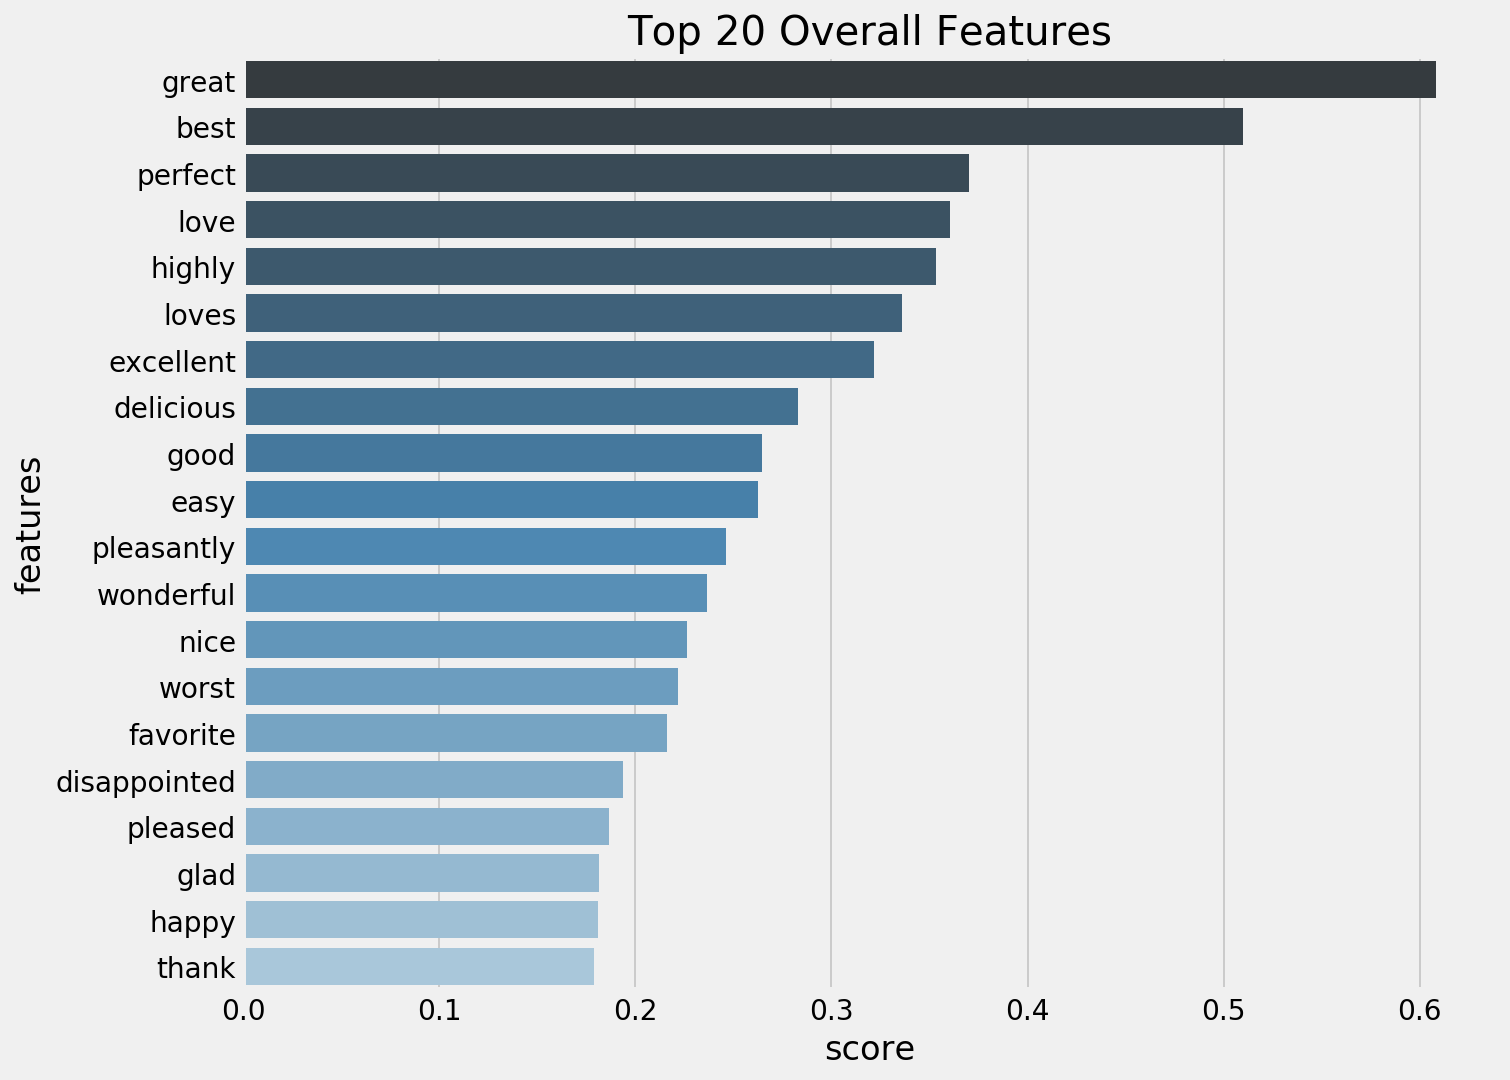

In [91]:
plt.style.use('fivethirtyeight')
sns.barplot(y='features', x='score', data=fimp, palette='Blues_d');
plt.title('Top 20 Overall Features');

In [92]:
W = clf.coef_.ravel()

In [93]:
fimp = get_top_n_features(n=20, weights=W, typ='-')

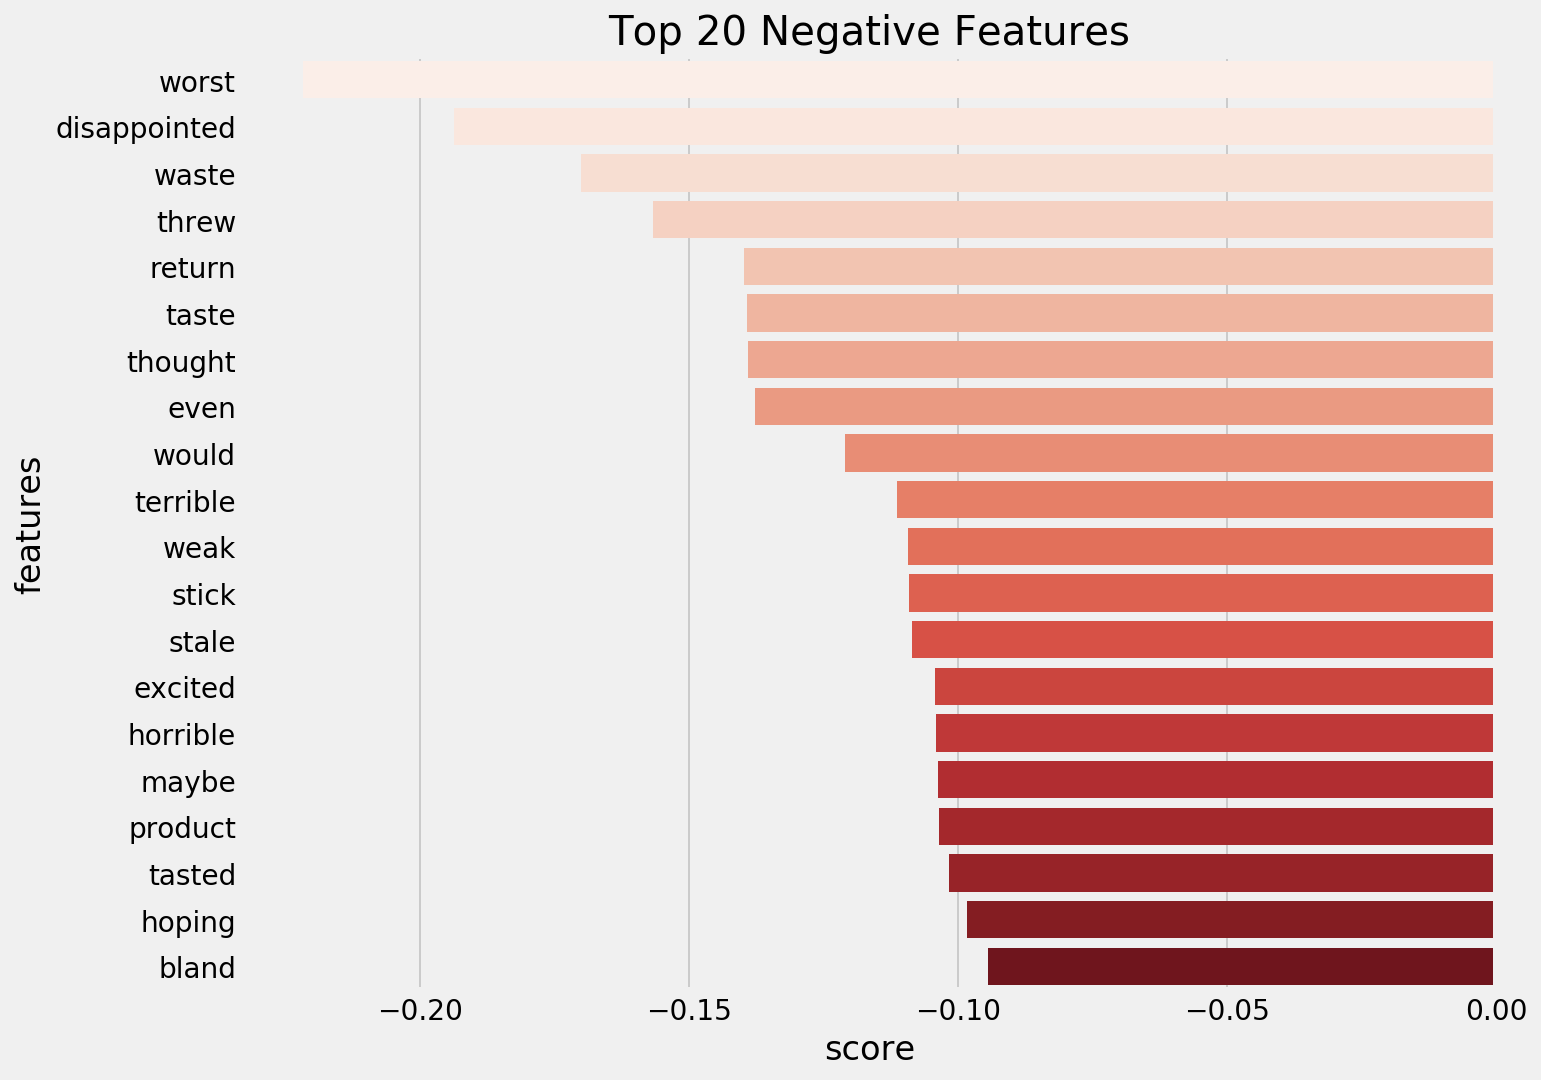

In [95]:
plt.style.use('fivethirtyeight')
sns.barplot(y='features', x='score', data=fimp, palette='Reds');
plt.title('Top 20 Negative Features');

In [96]:
fimp = get_top_n_features(n=20, weights=W, typ='+')

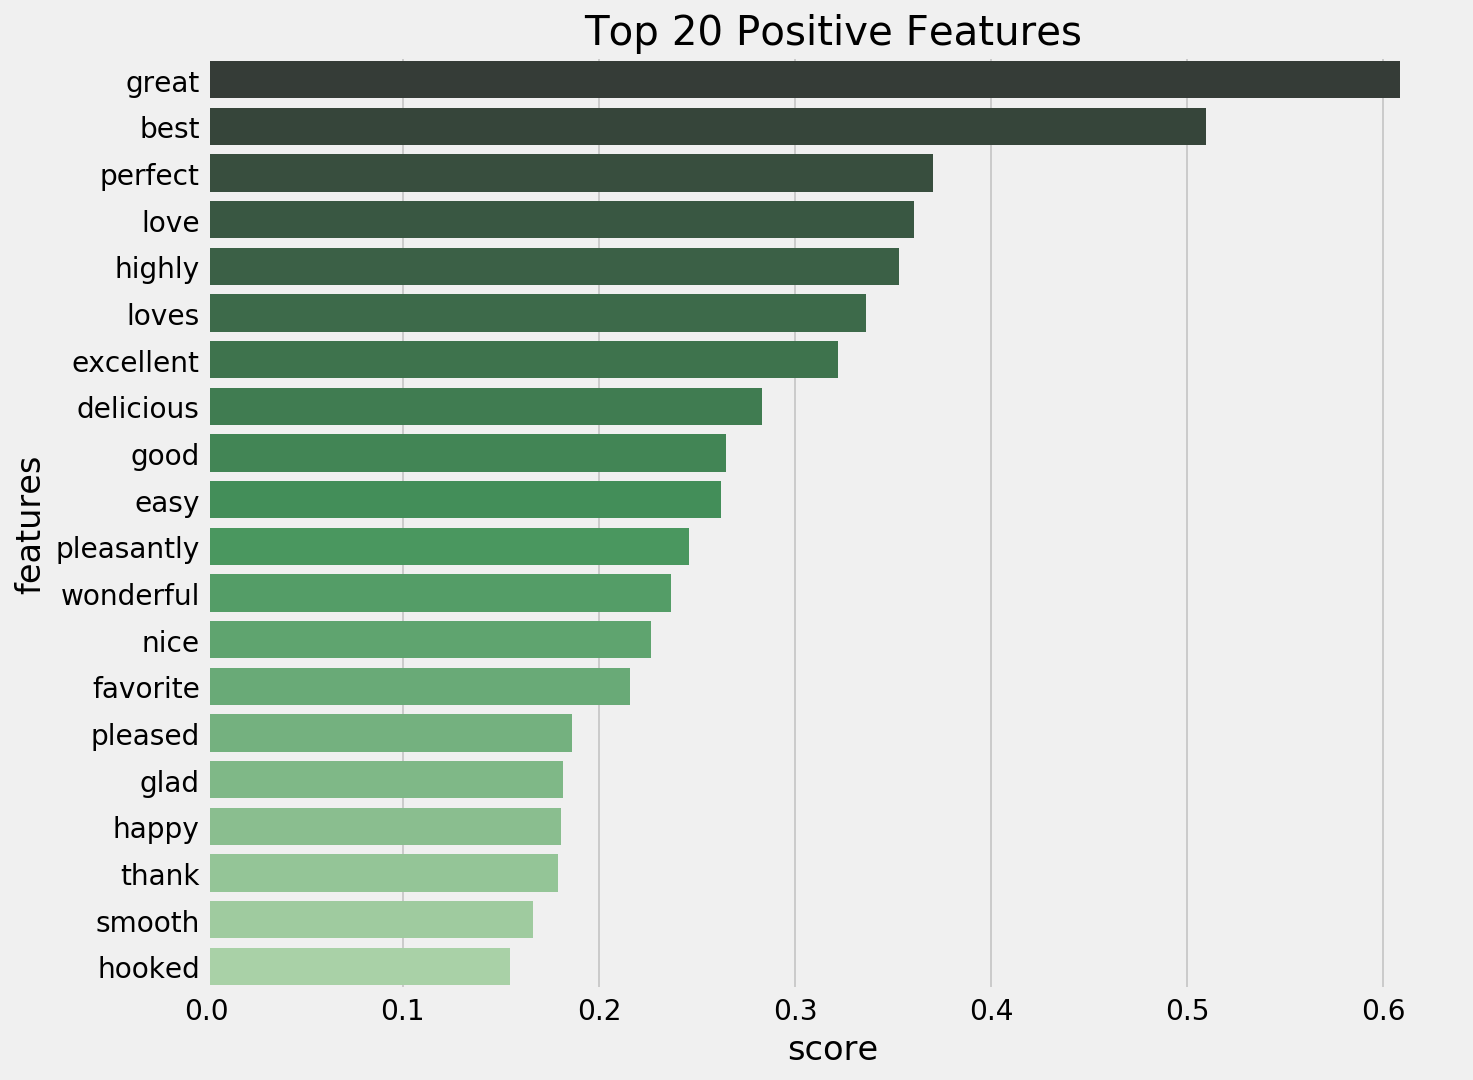

In [97]:
plt.style.use('fivethirtyeight')
sns.barplot(y='features', x='score', data=fimp, palette='Greens_d');
plt.title('Top 20 Positive Features');

## Multicolinearity & Pertubation

In [98]:
W1 = clf.coef_

In [99]:
Dtrain_scaled.shape

(254883, 3000)

In [100]:
Dtrain_scaled = Dtrain_scaled + np.random.normal(0, 0.01, Dtrain_scaled.shape)

In [102]:
clf2 = LogisticRegression(C=clf.C)

In [103]:
labels = data_train.Polarity.apply(lambda x: 1 if x == 'positive' else 0).values

In [104]:
clf2.fit(Dtrain_scaled, labels)

LogisticRegression(C=3.4892620474191727, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [105]:
W2 = clf2.coef_

In [106]:
W1 = W1.ravel()

In [107]:
W2 = W2.ravel()

In [108]:
from scipy.stats import ttest_ind

In [109]:
# compare samples
stat, p = ttest_ind(W1, W2)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=-0.000, p=1.000
Same distributions (fail to reject H0)


In [110]:
diff = np.abs(W1 - W2)

In [111]:
diff.sort()

In [112]:
p = pd.Series(diff[::-1][0:30])

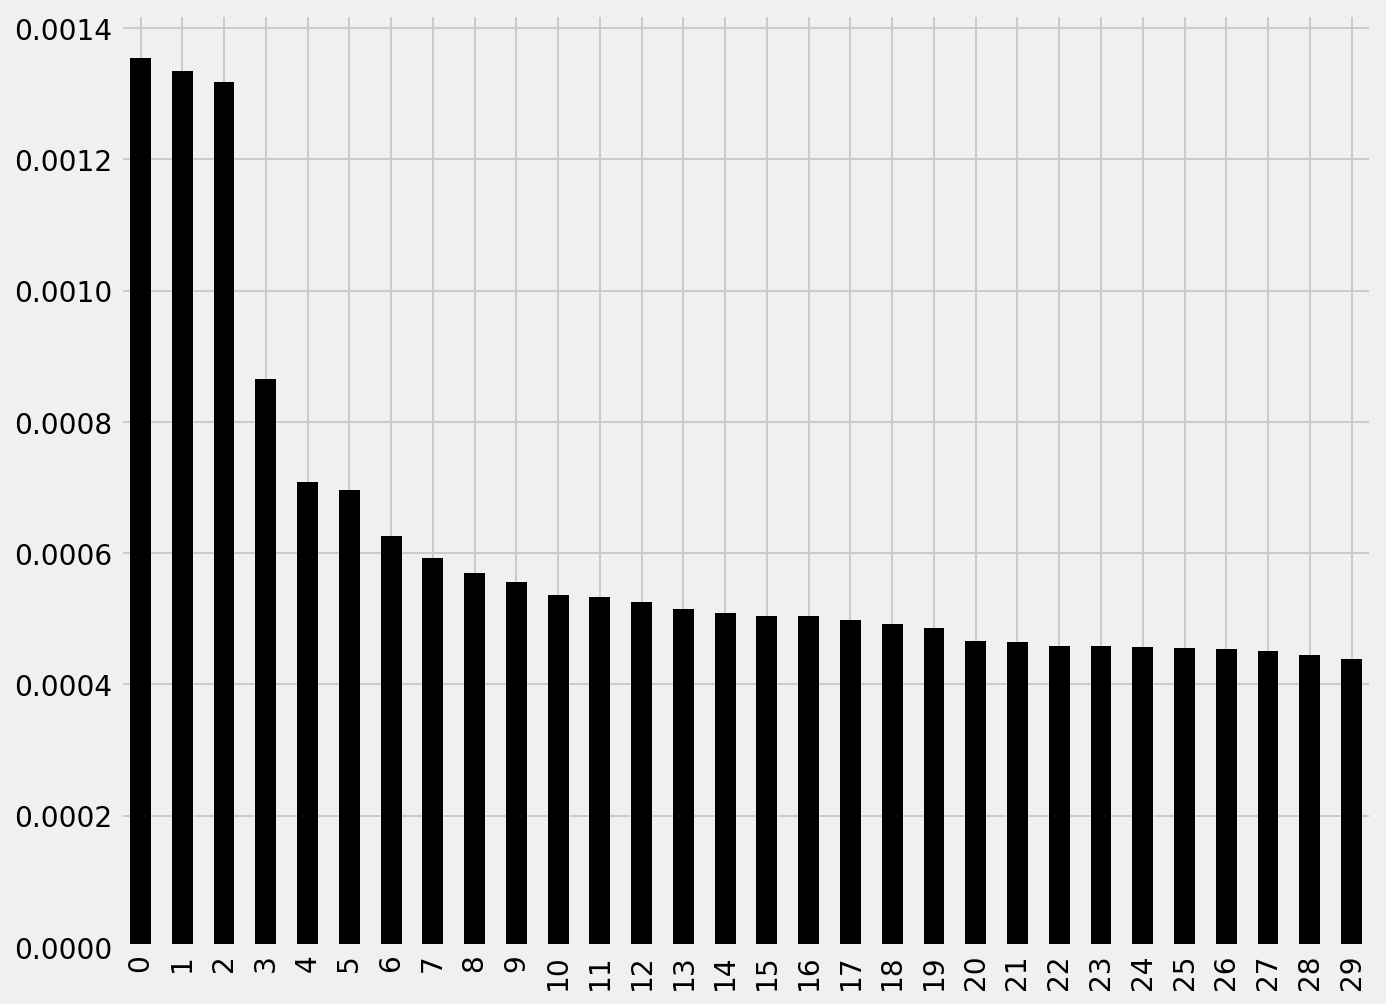

In [113]:
p.plot.bar(color='k');

In [114]:
diff.max()

0.0013542331748779002

As we can see just like the BOW, TFIDF also didn't come with any multicolinearity.

## Sparsity and Latency

In [115]:
features = Dtrain_scaled
labels = data_train.Polarity.apply(lambda x: 1 if x == 'positive' else 0).values

In [117]:
del Dtest

NameError: name 'Dtest' is not defined

In [118]:
clf3 = LogisticRegression(penalty='l1', C=1e-2, solver='saga', verbose=2)

In [119]:
estimators = []

In [120]:
for c in [1e-4, 1e-2, 1e-1, 1e0, 1e1]:
    clf = LogisticRegression(penalty='l1', C=c, solver='saga', max_iter=40, verbose=2)
    clf.fit(features, labels)
    estimators.append(clf)
    print(f"Done for c={c}")

convergence after 14 epochs took 160 seconds
Done for c=0.0001


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min finished


convergence after 19 epochs took 353 seconds
Done for c=0.01


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.9min finished


convergence after 27 epochs took 543 seconds
Done for c=0.1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.1min finished


convergence after 20 epochs took 409 seconds
Done for c=1.0


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.8min finished


convergence after 18 epochs took 371 seconds
Done for c=10.0


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.2min finished


In [141]:
latency = pd.DataFrame(columns=['C', 'sparsity', 'latency'])

In [142]:
xTrain = Dtest_scaled
actuals = data_test.Polarity.apply(lambda x: 1 if x == 'positive' else 0).values

In [143]:
spr = [np.nonzero(estimator.coef_.ravel())[0].shape[0] for estimator in estimators]
C = [1e-4, 1e-2, 1e-1, 1e0, 1e1]

In [144]:
import time

In [145]:
latn = []

In [146]:
for estimator in estimators:
    start = time.clock()
    estimator.predict(xTrain)
    latn.append(time.clock() - start)

In [150]:
latency['C'] = C
latency['sparsity'] = spr
latency['latency'] = latn

In [151]:
latency

,C,sparsity,latency
0,0.0001,6,1.357133
1,0.0100,2341,3.314542
2,0.1000,2922,3.325363
3,1.0000,2998,3.312711
4,10.0000,3000,3.308863
